In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **EDA**

In [4]:
oil = pd.read_excel("/content/RBRTEd (1).xls",sheet_name=1 , skiprows=2)
azn = pd.read_csv('/content/USD_AZN Historical Data.csv')

In [5]:
oil['Price']=oil['Europe Brent Spot Price FOB (Dollars per Barrel)']

In [6]:
oil = oil.drop('Europe Brent Spot Price FOB (Dollars per Barrel)',axis=1)

In [7]:
oil

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9579,2025-02-18,76.46
9580,2025-02-19,76.34
9581,2025-02-20,76.95
9582,2025-02-21,74.88


In [8]:
azn = azn.drop(['Open','High','Low','Vol.','Change %' ],axis=1)

In [9]:
azn['Azn'] = azn['Price']

In [10]:
azn = azn.drop('Price',axis=1)

In [11]:
azn

,Date,Azn
0,02/28/2025,1.7000
1,02/27/2025,1.7000
2,02/26/2025,1.6950
3,02/25/2025,1.6950
4,02/24/2025,1.6950
...,...,...
4993,01/10/2006,0.9184
4994,01/09/2006,0.9184
4995,01/06/2006,0.9187
4996,01/05/2006,0.9187


In [12]:
# Tarix sütunlarını uyğun formata salmaq
oil['Date'] = pd.to_datetime(oil['Date'], format='%Y-%m-%d')
azn['Date'] = pd.to_datetime(azn['Date'], format='%m/%d/%Y')

In [13]:
data = azn.set_index('Date').join(oil.set_index('Date'))

In [14]:
data.tail()

,Azn,Price
Date,,
2006-01-10,0.9184,62.32
2006-01-09,0.9184,62.51
2006-01-06,0.9187,62.43
2006-01-05,0.9187,61.68
2006-01-04,0.9187,61.25


In [15]:
data.head()

,Azn,Price
Date,,
2025-02-28,1.700,NaN
2025-02-27,1.700,NaN
2025-02-26,1.695,NaN
2025-02-25,1.695,NaN
2025-02-24,1.695,74.89


<Axes: xlabel='Date'>

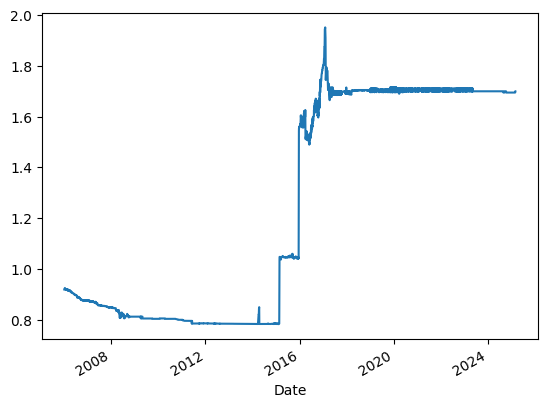

In [16]:
data['Azn'].plot()

<Axes: xlabel='Date'>

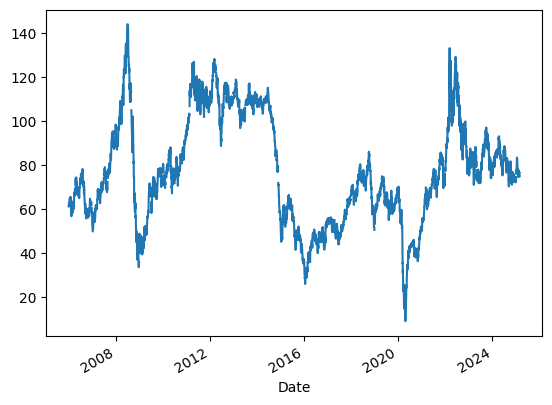

In [17]:
data['Price'].plot()

<Axes: >

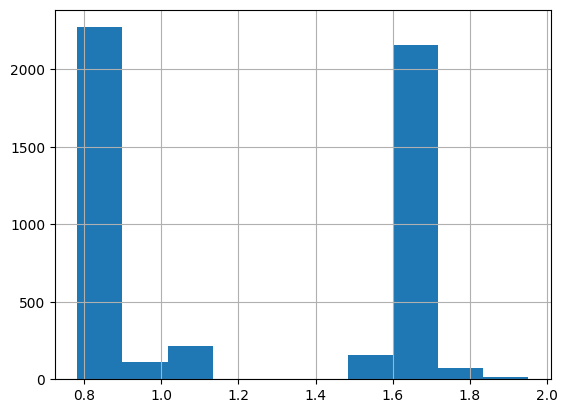

In [18]:
data['Azn'].hist()

<Axes: >

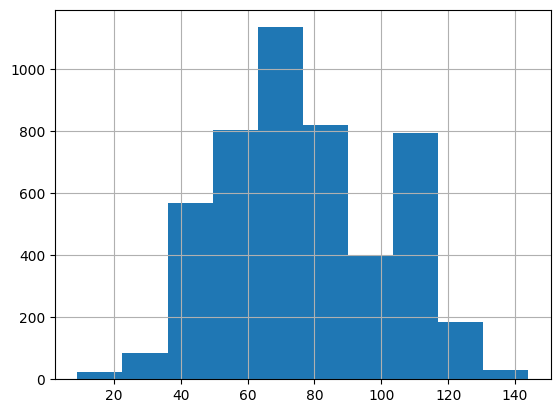

In [19]:
data['Price'].hist()

<Axes: >

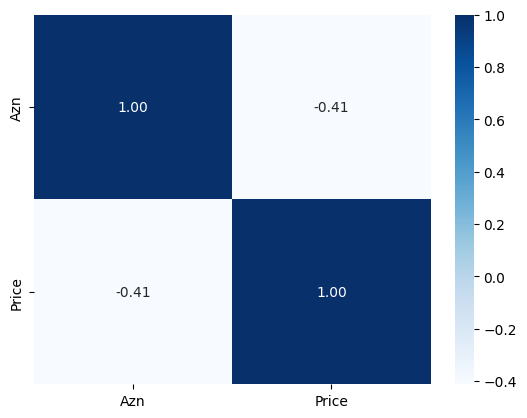

In [20]:
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='Blues')

In [21]:
data = data.reset_index()

# **Data Preparation**

In [22]:
data.isnull().sum()

,0
Date,0
Azn,0
Price,156


In [23]:
data = data.bfill()

In [24]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['WeekDay'] = data['Date'].dt.dayofweek

In [25]:
data = data.drop('Date', axis=1)

In [26]:
past_day = 7
# Son keçmiş günlərin USD və neft qiymətlərini uyğun sütunlara əlavə edirik
for day in range(past_day):
  data[f'price_azn_back{day+1}'] = data['Azn'].shift(day+1)
  data[f'price_oil_back{day+1}'] = data['Price'].shift(day+1)

In [27]:
data = data.dropna()

In [28]:
data.drop(columns=['Price'], inplace=True)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4991 entries, 7 to 4997
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Azn              4991 non-null   float64
 1   Year             4991 non-null   int32  
 2   Month            4991 non-null   int32  
 3   WeekDay          4991 non-null   int32  
 4   price_azn_back1  4991 non-null   float64
 5   price_oil_back1  4991 non-null   float64
 6   price_azn_back2  4991 non-null   float64
 7   price_oil_back2  4991 non-null   float64
 8   price_azn_back3  4991 non-null   float64
 9   price_oil_back3  4991 non-null   float64
 10  price_azn_back4  4991 non-null   float64
 11  price_oil_back4  4991 non-null   float64
 12  price_azn_back5  4991 non-null   float64
 13  price_oil_back5  4991 non-null   float64
 14  price_azn_back6  4991 non-null   float64
 15  price_oil_back6  4991 non-null   float64
 16  price_azn_back7  4991 non-null   float64
 17  price_oil_back7  49

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

In [31]:
X = data.drop(columns='Azn', axis=1)
y = data['Azn']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Building**

In [34]:
model = XGBRegressor()
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
preds = model.predict(X_test_scaled)

In [36]:
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
max_err = max_error(y_test, preds)

In [40]:
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print(f"Max Error: {max_err*100:.2f}")

Mean Squared Error: 0.00019479642965074132
Mean Absolute Error: 0.0036495074640349543
R-squared: 0.9989683213167383
Max Error: 24.26


# **Visualization**

Text(0, 0.5, 'Predicted Values')

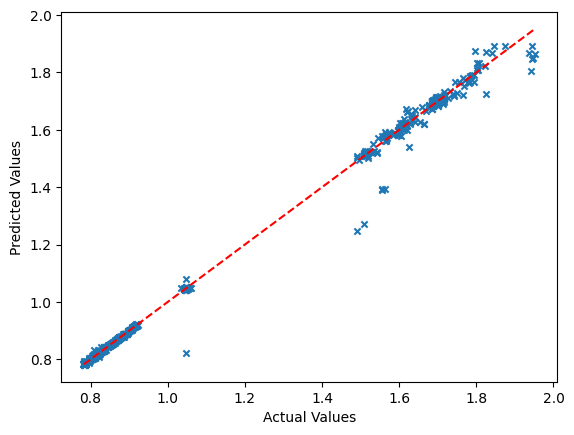

In [38]:
plt.scatter(y_test, preds, s=20, marker='x')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

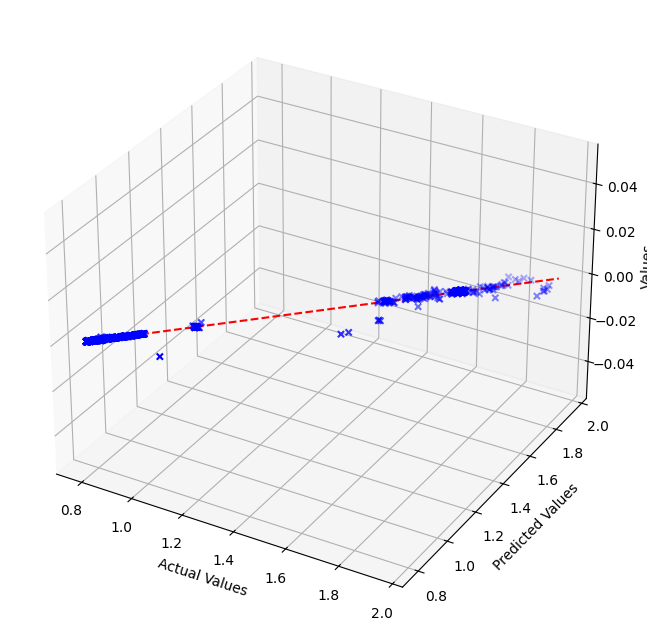

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3D plot yaratmaq üçün
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gerçək və təxmin edilmiş dəyərləri 3D qrafikdə vizuallaşdırmaq
ax.scatter(y_test, preds, c='blue', marker='x', s=20)

# Qırmızı xətt əlavə etmək: Gerçək dəyərlərlə təxmin edilmiş dəyərlər arasında mükəmməl uyğunluq
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Əsas etiketləri əlavə etmək
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_zlabel('Values')

# Plot göstərmək
plt.show()
